# Playground Series S5E9 — Fast, Efficient Tri‑Blend (LGBM + XGB + CatBoost)

This notebook implements a **head‑to‑tail, fast, and competitive baseline** for the Kaggle Playground Series S5E9 (Predicting the Beats‑per‑Minute of Songs).  
It follows a proven recipe that’s been consistently strong on tabular regression: **5‑fold CV**, **LightGBM / XGBoost / CatBoost**, and a small **weighted blend** tuned on OOF predictions.

**Highlights**
- Minimal preprocessing (label‑encode object cols, median impute numeric).
- Strong defaults with early stopping (fast) + 5‑fold CV (reliable).
- Tiny, grid‑searched blend weights that usually beat any single model.
- Produces **OOF CV metrics**, **feature importances**, and **submission.csv**.

> Tip: If you want an extra ~0.005–0.01 RMSE, duplicate models with 2–3 different `SEEDS` and average per‑model before blending. This notebook starts with one seed for speed.

## 1. Setup & Configuration

In [1]:
# =========================
# Configuration & Imports
# =========================
import os, math, gc, warnings, sys
import random
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

# Tree models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

# Plotting
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Kaggle input path (use Kaggle runtime path when available, else fall back to local workspace)
# On Kaggle this is /kaggle/input/playground-series-s5e9; locally we expect kaggle/input/playground-series-s5e9 under the repo
KAGGLE_PATH = Path("/kaggle/input/playground-series-s5e9")
LOCAL_FALLBACK = Path("./kaggle/input/playground-series-s5e9").resolve()
if KAGGLE_PATH.exists():
    INPUT_DIR = KAGGLE_PATH
    OUTPUT_DIR = Path("/kaggle/working")
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    print("Running on Kaggle runtime; using /kaggle paths.")
else:
    # Fall back to local workspace path (useful when running locally or in CI)
    if LOCAL_FALLBACK.exists():
        INPUT_DIR = LOCAL_FALLBACK
        OUTPUT_DIR = Path("./working").resolve()
        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        print(f"Kaggle dataset not found at /kaggle — using local fallback: {INPUT_DIR}")
    else:
        raise AssertionError(f"Expected dataset at /kaggle/input/playground-series-s5e9 or local {LOCAL_FALLBACK} — create the folder or update INPUT_DIR accordingly")

# Repro
SEEDS = [42, 1337, 2025]
SEED = SEEDS[0]

def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

# Cross-validation
N_SPLITS = 5
SHUFFLE = True

# Early stopping patience
EARLY_STOPPING = 400

Kaggle dataset not found at /kaggle — using local fallback: D:\bpm-prediction\kaggle\input\playground-series-s5e9


## 2. Load Data

In [2]:
# =========================
# Load train / test / sample
# =========================
train_path = INPUT_DIR / "train.csv"
test_path  = INPUT_DIR / "test.csv"
sub_path   = INPUT_DIR / "sample_submission.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
sample_submission = pd.read_csv(sub_path)

print("Train shape:", train.shape)
print("Test  shape:", test.shape)
display(train.head(3))
display(test.head(3))
display(sample_submission.head(3))

# Identify ID and TARGET
# Most likely: id / bpm. We'll infer TARGET from sample_submission (2nd column).
ID_COL = "id" if "id" in train.columns else train.columns[0]
TARGET = sample_submission.columns[1] if len(sample_submission.columns) >= 2 else "bpm"
assert TARGET in train.columns, f"Could not find target '{TARGET}' in train columns {train.columns.tolist()}"
print(f"Using ID_COL='{ID_COL}', TARGET='{TARGET}'")

Train shape: (524164, 11)
Test  shape: (174722, 10)


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067


,id,BeatsPerMinute
0,524164,119.035
1,524165,119.035
2,524166,119.035


Using ID_COL='id', TARGET='BeatsPerMinute'


## 3. Minimal Preprocessing

In [3]:
# =========================
# Minimal preprocessing
# - Label-encode object cols (fit on combined train+test)
# - Fill numeric NAs with median; object NAs to 'NA'
# =========================
from sklearn.preprocessing import LabelEncoder

# Separate feature columns
features = [c for c in train.columns if c not in [ID_COL, TARGET]]
X = train[features].copy()
X_test = test[features].copy()

# Detect dtypes
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Label-encode object columns using combined train+test categories
for col in obj_cols:
    le = LabelEncoder()
    combined = pd.concat([X[col], X_test[col]], axis=0).astype(str).fillna("NA")
    le.fit(combined)
    X[col] = le.transform(X[col].astype(str).fillna("NA"))
    X_test[col] = le.transform(X_test[col].astype(str).fillna("NA"))

# Fill numeric NAs with median
for col in num_cols:
    med = X[col].median()
    X[col] = X[col].fillna(med)
    X_test[col] = X_test[col].fillna(med)

y = train[TARGET].values

print(f"Features: {len(features)} | Numeric: {len(num_cols)} | Object-encoded: {len(obj_cols)}")

Features: 9 | Numeric: 9 | Object-encoded: 0


## 4. CV Helper & Metric

In [4]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Standard KFold (always available)
kf = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=SEED)

# Stratified via quantile bins (regression-friendly).
STRATIFY_Q = 10  # base quantile bucket count; increase if the dataset is large
use_stratified = False
skf = None
bins = None
try:
    quantile_candidates = []
    for q in [STRATIFY_Q, 20, N_SPLITS]:
        if q is None:
            continue
        q_int = int(max(2, q))
        if q_int not in quantile_candidates:
            quantile_candidates.append(q_int)
    for q in quantile_candidates:
        candidate_bins = None
        try:
            candidate_bins = pd.qcut(y, q=q, labels=False, duplicates="drop")
        except ValueError:
            candidate_bins = pd.cut(y, bins=q, labels=False, include_lowest=True)
        candidate_bins = np.asarray(candidate_bins)
        if candidate_bins.dtype.kind not in "iu":
            try:
                candidate_bins = candidate_bins.astype(int)
            except Exception:
                candidate_bins = candidate_bins.astype(float)
        mask = ~pd.isna(candidate_bins)
        n_unique_bins = len(np.unique(candidate_bins[mask]))
        if n_unique_bins >= N_SPLITS:
            bins = candidate_bins
            if mask.sum() != len(candidate_bins):
                if mask.any():
                    mode_bin = pd.Series(candidate_bins[mask]).mode().iloc[0]
                else:
                    mode_bin = 0
                bins = np.where(mask, bins, mode_bin)
            skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=SEED)
            use_stratified = True
            print(f"Using StratifiedKFold with q={q} -> {n_unique_bins} target bins")
            break
    if not use_stratified:
        print("Quantile binning could not produce >= N_SPLITS unique bins; using plain KFold instead.")
        bins = None
except Exception as e:
    use_stratified = False
    skf = None
    bins = None
    print('Could not prepare stratified bins; using KFold. Error:', e)

Using StratifiedKFold with q=10 -> 10 target bins


## 5. Model Configurations (Regularized & Fast)

In [5]:
# =========================
# Base parameters chosen for speed and stability.
# Increase n_estimators if you disable early stopping.
# =========================
lgb_params_base = dict(
    objective="regression", metric="rmse",
    learning_rate=0.03, num_leaves=64, max_depth=-1,
    min_data_in_leaf=40, feature_fraction=0.9, bagging_fraction=0.9,
    bagging_freq=1, reg_lambda=2.0, reg_alpha=0.2, n_estimators=4000,
)

xgb_params_base = dict(
    objective="reg:squarederror", tree_method="hist",
    learning_rate=0.03, max_depth=7, min_child_weight=8,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=2.0, reg_alpha=0.2,
    n_estimators=4000,
)

cat_params_base = dict(
    loss_function="RMSE", depth=8, learning_rate=0.03,
    l2_leaf_reg=6.0, iterations=4000,
    od_type="Iter", od_wait=EARLY_STOPPING, verbose=0,
)

## 6. Train with 5‑Fold CV & Collect OOF / Predictions

### Multi-seed training
The loop below runs each model over `SEEDS = [42, 1337, 2025]`, accumulates OOF predictions / feature importances per seed, and averages them before blending. Adjust the list to explore additional seeds.

In [6]:
# Containers (seed-averaged accumulators)
oof_lgb = np.zeros(len(X), dtype=float)
oof_xgb = np.zeros(len(X), dtype=float)
oof_cat = np.zeros(len(X), dtype=float)

pred_lgb = np.zeros(len(X_test), dtype=float)
pred_xgb = np.zeros(len(X_test), dtype=float)
pred_cat = np.zeros(len(X_test), dtype=float)

# For importances
fi_lgb = np.zeros(len(features), dtype=float)
fi_xgb = np.zeros(len(features), dtype=float)
fi_cat = np.zeros(len(features), dtype=float)

rmse_lgb_seeds, rmse_xgb_seeds, rmse_cat_seeds = [], [], []

for seed_idx, seed in enumerate(SEEDS, 1):
    print(f"\n>>> Seed {seed_idx}/{len(SEEDS)} | seed={seed}")
    seed_everything(seed)

    oof_lgb_seed = np.zeros(len(X), dtype=float)
    oof_xgb_seed = np.zeros(len(X), dtype=float)
    oof_cat_seed = np.zeros(len(X), dtype=float)

    pred_lgb_seed = np.zeros(len(X_test), dtype=float)
    pred_xgb_seed = np.zeros(len(X_test), dtype=float)
    pred_cat_seed = np.zeros(len(X_test), dtype=float)

    fi_lgb_seed = np.zeros(len(features), dtype=float)
    fi_xgb_seed = np.zeros(len(features), dtype=float)
    fi_cat_seed = np.zeros(len(features), dtype=float)

    if use_stratified and skf is not None and bins is not None:
        splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=seed if SHUFFLE else None)
        split_generator = splitter.split(X, bins)
        splitter_name = "StratifiedKFold"
    else:
        splitter = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=seed if SHUFFLE else None)
        split_generator = splitter.split(X, y)
        splitter_name = "KFold"
    print(f"Using {splitter_name} for cross-validation.")

    for fold, (tr_idx, va_idx) in enumerate(split_generator, 1):
        X_tr, y_tr = X.iloc[tr_idx], y[tr_idx]
        X_va, y_va = X.iloc[va_idx], y[va_idx]

        print(f"\n=== Seed {seed} | Fold {fold}/{N_SPLITS} ===")

        # LightGBM
        lgb_params = {**lgb_params_base, "random_state": seed}
        lgbm = lgb.LGBMRegressor(**lgb_params)
        lgbm.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            callbacks=[lgb.early_stopping(EARLY_STOPPING), lgb.log_evaluation(0)]
        )
        oof_lgb_seed[va_idx] = lgbm.predict(X_va, num_iteration=lgbm.best_iteration_)
        pred_lgb_seed += lgbm.predict(X_test, num_iteration=lgbm.best_iteration_) / N_SPLITS
        try:
            fi_lgb_seed += lgbm.feature_importances_ / N_SPLITS
        except Exception:
            pass

        # XGBoost
        xgb_params = {**xgb_params_base, "random_state": seed}
        xgbm = xgb.XGBRegressor(**xgb_params)
        # Newer xgboost versions expect callbacks instead of the early_stopping_rounds kwarg
        # use the callback API for compatibility across versions.
        try:
            xgbm.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                verbose=False,
                callbacks=[xgb.callback.EarlyStopping(rounds=EARLY_STOPPING, save_best=True)]
            )
        except TypeError:
            # Fallback for very old/new APIs: try without callbacks (may still work)
            xgbm.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
        # Safely obtain best_iteration if available; else let predict use full model
        best_iter = getattr(xgbm, 'best_iteration', None)
        if best_iter is None:
            # Some xgboost builds store best_ntree_limit instead
            best_iter = getattr(xgbm, 'best_ntree_limit', None)
        try:
            if best_iter is not None:
                oof_xgb_seed[va_idx] = xgbm.predict(X_va, iteration_range=(0, int(best_iter)+1))
                pred_xgb_seed += xgbm.predict(X_test, iteration_range=(0, int(best_iter)+1)) / N_SPLITS
            else:
                oof_xgb_seed[va_idx] = xgbm.predict(X_va)
                pred_xgb_seed += xgbm.predict(X_test) / N_SPLITS
        except Exception:
            # Last-resort: plain predict without special args
            oof_xgb_seed[va_idx] = xgbm.predict(X_va)
            pred_xgb_seed += xgbm.predict(X_test) / N_SPLITS
        try:
            fi_xgb_seed += xgbm.feature_importances_ / N_SPLITS
        except Exception:
            pass

        # CatBoost
        cat_params = {**cat_params_base, "random_seed": seed}
        cat = CatBoostRegressor(**cat_params)
        cat.fit(Pool(X_tr, y_tr), eval_set=Pool(X_va, y_va), use_best_model=True)
        oof_cat_seed[va_idx] = cat.predict(X_va)
        pred_cat_seed += cat.predict(X_test) / N_SPLITS
        try:
            fi_cat_seed += cat.get_feature_importance(Pool(X_va, y_va)) / N_SPLITS
        except Exception:
            pass

    # Aggregate seed-level outputs
    oof_lgb += oof_lgb_seed
    oof_xgb += oof_xgb_seed
    oof_cat += oof_cat_seed

    pred_lgb += pred_lgb_seed
    pred_xgb += pred_xgb_seed
    pred_cat += pred_cat_seed

    fi_lgb += fi_lgb_seed
    fi_xgb += fi_xgb_seed
    fi_cat += fi_cat_seed

    rmse_lgb_seed = rmse(y, oof_lgb_seed)
    rmse_xgb_seed = rmse(y, oof_xgb_seed)
    rmse_cat_seed = rmse(y, oof_cat_seed)

    rmse_lgb_seeds.append(rmse_lgb_seed)
    rmse_xgb_seeds.append(rmse_xgb_seed)
    rmse_cat_seeds.append(rmse_cat_seed)

    print(f"Seed {seed} OOF RMSEs -> LightGBM: {rmse_lgb_seed:.6f} | XGBoost: {rmse_xgb_seed:.6f} | CatBoost: {rmse_cat_seed:.6f}")

seed_count = len(SEEDS)
oof_lgb /= seed_count
oof_xgb /= seed_count
oof_cat /= seed_count

pred_lgb /= seed_count
pred_xgb /= seed_count
pred_cat /= seed_count

fi_lgb /= seed_count
fi_xgb /= seed_count
fi_cat /= seed_count

# CV metrics
rmse_lgb = rmse(y, oof_lgb)
rmse_xgb = rmse(y, oof_xgb)
rmse_cat = rmse(y, oof_cat)

print("\nOOF RMSEs (seed-averaged):")
print(f"  LightGBM : {rmse_lgb:.6f} (per-seed: {', '.join(f'{v:.6f}' for v in rmse_lgb_seeds)})")
print(f"  XGBoost  : {rmse_xgb:.6f} (per-seed: {', '.join(f'{v:.6f}' for v in rmse_xgb_seeds)})")
print(f"  CatBoost : {rmse_cat:.6f} (per-seed: {', '.join(f'{v:.6f}' for v in rmse_cat_seeds)})")


>>> Seed 1/3 | seed=42
Using StratifiedKFold for cross-validation.

=== Seed 42 | Fold 1/5 ===
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be i

## 7. Simple Weighted Blend (Grid Search on OOF)

### Linear calibration of blend
We fit a simple `LinearRegression` on the blend OOF predictions vs. the ground truth, then apply it to both OOF and test predictions to correct any slope/intercept bias.

In [12]:
from sklearn.linear_model import LinearRegression

oof_blend_raw = oof_blend.copy()
pred_blend_raw = pred_blend.copy()

calibration_model = LinearRegression()
calibration_model.fit(oof_blend_raw.reshape(-1, 1), y)

cal_slope = float(calibration_model.coef_[0])
cal_intercept = float(calibration_model.intercept_)

rmse_blend_raw = rmse(y, oof_blend_raw)
oof_blend_cal = calibration_model.predict(oof_blend_raw.reshape(-1, 1))
rmse_blend_cal = rmse(y, oof_blend_cal)

pred_blend_cal = calibration_model.predict(pred_blend_raw.reshape(-1, 1))

print(f"Calibration slope: {cal_slope:.6f} | intercept: {cal_intercept:.6f}")
print(f"Blend RMSE (uncalibrated): {rmse_blend_raw:.6f}")
print(f"Blend RMSE (calibrated):   {rmse_blend_cal:.6f}")
print(f"RMSE delta (cal - raw):     {rmse_blend_cal - rmse_blend_raw:+.6f}")

# Make calibrated predictions the default downstream values
oof_blend = oof_blend_cal
pred_blend = pred_blend_cal

Calibration slope: 1.151642 | intercept: -18.050748
Blend RMSE (uncalibrated): 26.457897
Blend RMSE (calibrated):   26.457717
RMSE delta (cal - raw):     -0.000179


In [11]:
# Compute blend weights using NNLS (non-negative least squares) and RidgeCV
# Inputs are already averaged across seeds in the previous step.
A = np.vstack([oof_lgb, oof_xgb, oof_cat]).T  # [n_samples, n_models]

# NNLS (non-negative weights)
try:
    from scipy.optimize import nnls
except Exception:
    nnls = None
from sklearn.linear_model import RidgeCV

if nnls is not None:
    try:
        w_nnls, _ = nnls(A, y)
        if w_nnls.sum() > 0:
            w_nnls = w_nnls / w_nnls.sum()
        oof_nnls = A @ w_nnls
        rmse_nnls = rmse(y, oof_nnls)
    except Exception as e:
        print('NNLS failed:', e)
        w_nnls = np.array([1/3, 1/3, 1/3])
        rmse_nnls = 1e9
else:
    print('SciPy.nnls not available; skipping NNLS')
    w_nnls = np.array([1/3, 1/3, 1/3])
    rmse_nnls = 1e9

# Ridge (no intercept) with cross-validated alpha; allows negative weights
try:
    ridge = RidgeCV(alphas=np.logspace(-6, 2, 25), fit_intercept=False, cv=5)
    ridge.fit(A, y)
    w_ridge = ridge.coef_.copy()
    # normalize to sum=1 for interpretability (if sum is zero, fall back)
    if w_ridge.sum() != 0:
        w_ridge = w_ridge / w_ridge.sum()
    oof_ridge = A @ w_ridge
    rmse_ridge = rmse(y, oof_ridge)
except Exception as e:
    print('RidgeCV failed:', e)
    w_ridge = np.array([1/3, 1/3, 1/3])
    rmse_ridge = 1e9

# Choose the best blending method by OOF RMSE
if rmse_ridge <= rmse_nnls:
    w = w_ridge
    best_method = 'RidgeCV'
    best_rmse = rmse_ridge
else:
    w = w_nnls
    best_method = 'NNLS'
    best_rmse = rmse_nnls

oof_blend = A @ w
w1, w2, w3 = w.tolist()
print(f"Selected blend: {best_method} | OOF RMSE: {best_rmse:.6f} | weights (LGB, XGB, CAT) = {w}")

# Final (test) predictions using chosen weights
pred_blend = w[0] * pred_lgb + w[1] * pred_xgb + w[2] * pred_cat

Selected blend: RidgeCV | OOF RMSE: 26.457897 | weights (LGB, XGB, CAT) = [ 1.09877133  0.00589741 -0.10466875]


## 8. Create Submission

In [13]:
submission = sample_submission.copy()
submission[submission.columns[1]] = pred_blend  # set target column values
submission_path = OUTPUT_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
submission.head()

,id,BeatsPerMinute
0,524164,119.144719
1,524165,118.668856
2,524166,119.546014
3,524167,119.337950
4,524168,119.510902


## 9. Feature Importances (Average Across Folds)

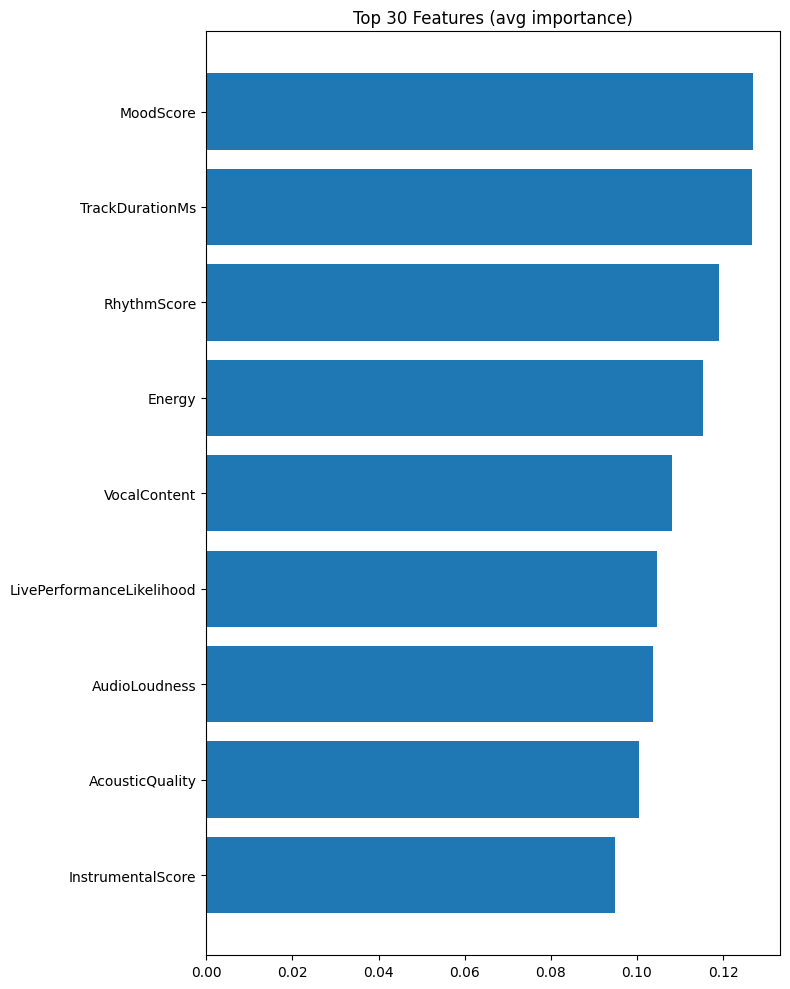

In [14]:
# Average normalized importances from the three models (when available)
importances = pd.DataFrame({
    "feature": features,
    "lgb": fi_lgb,
    "xgb": fi_xgb,
    "cat": fi_cat
})

# Normalize each column (avoid divide by zero)
for col in ["lgb", "xgb", "cat"]:
    s = importances[col].sum()
    importances[col] = importances[col] / s if s > 0 else importances[col]

importances["avg"] = importances[["lgb", "xgb", "cat"]].mean(axis=1)
imp_top = importances.sort_values("avg", ascending=False).head(30)

plt.figure(figsize=(8, 10))
plt.barh(imp_top["feature"][::-1], imp_top["avg"][::-1])
plt.title("Top 30 Features (avg importance)")
plt.tight_layout()
plt.show()

## 10. OOF Diagnostics

,id,BeatsPerMinute,oof_blend_raw,oof_blend_cal,resid_raw,resid_cal
0,0,147.53020,118.701839,118.651260,-28.828361,-28.878940
1,1,136.15963,118.580047,118.511000,-17.579583,-17.648630
2,2,55.31989,118.850527,118.822496,63.530637,63.502606
3,3,147.91212,118.746000,118.702118,-29.166120,-29.210002
4,4,89.58511,119.073570,119.079362,29.488460,29.494252


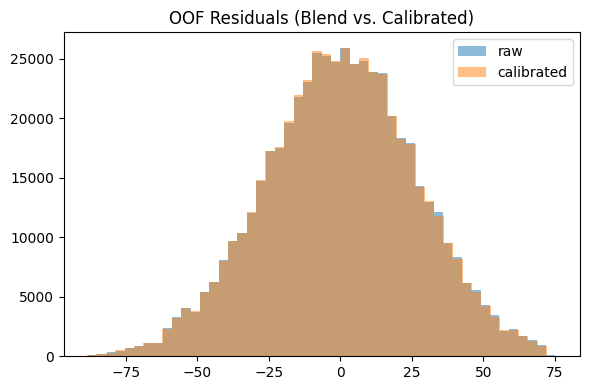

In [15]:
oof_df = pd.DataFrame({
    ID_COL: train[ID_COL],
    TARGET: y,
    "oof_lgb": oof_lgb,
    "oof_xgb": oof_xgb,
    "oof_cat": oof_cat,
    "oof_blend_raw": oof_blend_raw,
    "oof_blend_cal": oof_blend,
})
oof_df["resid_raw"] = oof_df["oof_blend_raw"] - oof_df[TARGET]
oof_df["resid_cal"] = oof_df["oof_blend_cal"] - oof_df[TARGET]

display(oof_df[[ID_COL, TARGET, "oof_blend_raw", "oof_blend_cal", "resid_raw", "resid_cal"]].head())

plt.figure(figsize=(6,4))
plt.hist(oof_df["resid_raw"], bins=50, alpha=0.5, label="raw")
plt.hist(oof_df["resid_cal"], bins=50, alpha=0.5, label="calibrated")
plt.title("OOF Residuals (Blend vs. Calibrated)")
plt.legend()
plt.tight_layout()
plt.show()

## 11. Next Steps (Optional)

- **Seed diversity**: set `SEEDS = [42, 1337, 2025]` and average per‑model across seeds before blending.
- **Light FE**: Try a few pairwise interactions among the top features (add `<f_i> * <f_j>`), but keep extras under ~30.
- **Tune grid granularity**: tighten the blend search around the best weights with finer steps (e.g., 0.01) once CV stabilizes.
- **Submission strategy**: keep submissions to a few strong variants validated by CV; avoid leaderboard overfitting.